In [52]:
import albumentations as A
import numpy as np
import onnx
import onnxruntime
from albumentations.pytorch import ToTensorV2
from PIL import Image

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline


In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [54]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


In [55]:
model_path = "../../checkpoints/best.onnx"
# image_path = "../../images/SM.png"
image_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/DSC_0050.jpg"


In [56]:
onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)


In [57]:
session = onnxruntime.InferenceSession(model_path)


(8256, 5504)


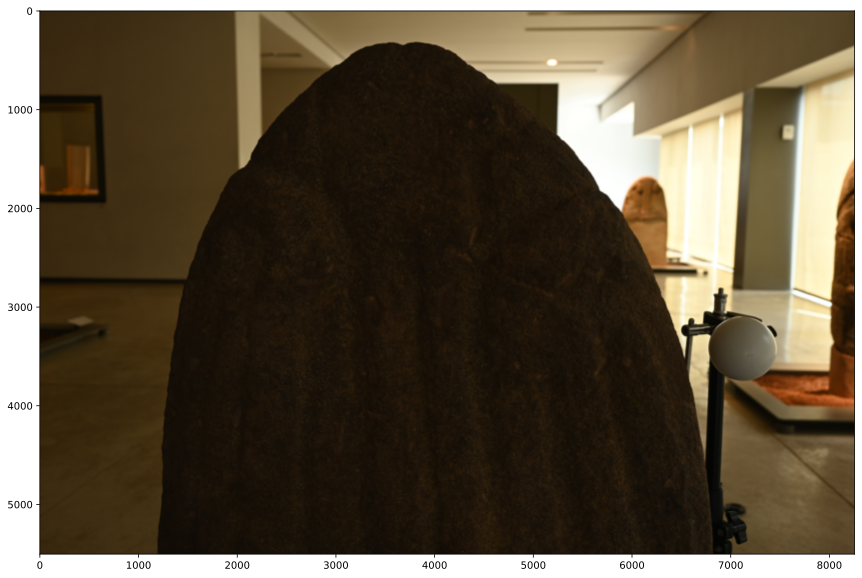

In [58]:
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(25, 10))
plt.imshow(image)

print(image.size)


In [59]:
transform = A.Compose(
    [
        A.LongestMaxSize(1024),
        A.ToFloat(max_value=255), # [0, 255] -> [0.0, 1.0]
        ToTensorV2(), # HWC -> CHW
    ],
)
aug = transform(image=np.asarray(image))
img = aug["image"]

img = img.unsqueeze(0) # -> 1CHW

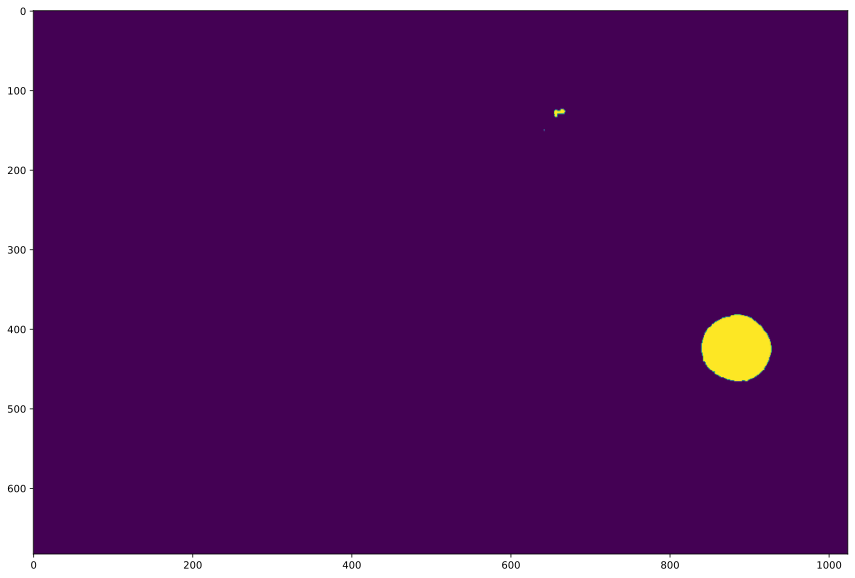

In [60]:
inputs = {
    session.get_inputs()[0].name: to_numpy(img),
}

outs = session.run(None, inputs)

img_out = outs[0][0][0] # extract HW
img_out = img_out * 255 # [0.0, 255.0]
img_out = img_out.clip(0, 255) 
img_out = np.uint8(img_out) # [0, 255]
img_out = Image.fromarray(img_out, "L") # PIL img

plt.figure(figsize=(25, 10))
plt.imshow(img_out)


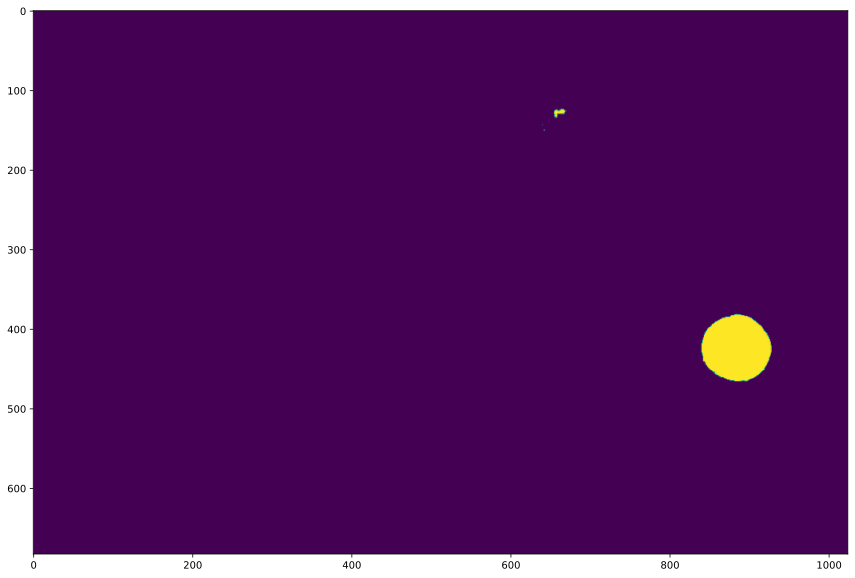

In [61]:
img_out = outs[0][0][0] # extract HW
img_out = sigmoid(img_out) # -> [0.0, 1.0]
img_out = img_out * 255 # [0.0, 255.0]
img_out = np.uint8(img_out) # [0, 255]
img_out = Image.fromarray(img_out, "L") # PIL img

plt.figure(figsize=(25, 10))
plt.imshow(img_out)


In [62]:
import torch
from utils.dice import dice_score

In [ ]:
image_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/DSC_0050.jpg"
gt_path = "/home/lilian/data_disk/lfainsin/test/2022_SM/DOS_DETAIL/MASK.PNG"

image = Image.open(image_path).convert("RGB")
image = torch.tensor(np.uint8(image))

ground_truth = Image.open(gt_path).convert("L")
ground_truth = torch.tensor(np.uint8(ground_truth))

dices = []
rezs = range(128, 4096+4, 4)

for rez in rezs:

    print(rez, end="\r")

    transform = A.Compose(
        [
            A.LongestMaxSize(rez),
            A.ToFloat(max_value=255), # [0, 255] -> [0.0, 1.0]
            ToTensorV2(), # HWC -> CHW
        ],
    )
    aug = transform(image=np.array(image))
    img = aug["image"]
    img = img.unsqueeze(0) # -> 1CHW

    inputs = {
        session.get_inputs()[0].name: to_numpy(img),
    }
    outs = session.run(None, inputs)

    img_out = outs[0][0][0] # extract HW
    img_out = sigmoid(img_out) # -> [0.0, 1.0]
    img_out = img_out > 0.5 # {False, True}
    img_out = np.uint8(img_out) # [0, 1]
    img_out = torch.tensor(img_out)

    aug = transform(image=np.array(ground_truth))
    gt = aug["image"]
    gt = gt > 0.1 # {False, True}
    gt = np.uint8(gt) # [0, 1]
    gt = torch.tensor(gt)

    dice = dice_score(gt, img_out, logits=False)
    dices.append(dice)


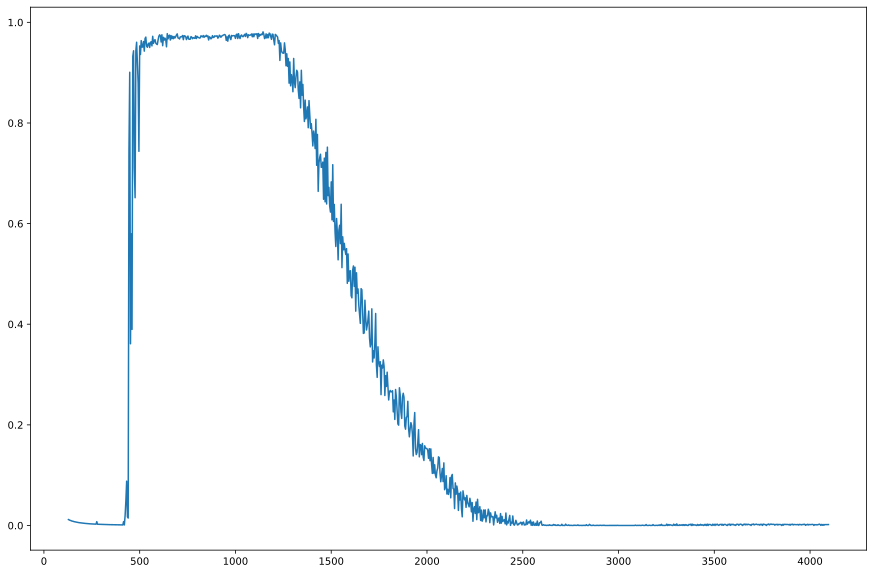

In [64]:
plt.figure(figsize=(15, 10))
plt.plot(rezs, dices)
